# Case  Study of  Vehicle Routing Problem with Parameter Prediction Model using Sklearn and MiniZinc

## Overview
This case study is adapted from ["Incorporation of parameter prediction models of different fidelity into job shop scheduling"](https://www.sciencedirect.com/science/article/pii/S2405896319301363). 

In the study, the researchers used a [publicly available dataset](https://www.kaggle.com/c/nyc-taxi-trip-duration) to propose a scheduling problem.

Here is the excerpt of the problem:

" We now define a scheduling problem that is based on the dataset but has features that are transferable to industrial job shop scheduling. Let us consider a company, which head quarter is at Wall Street 2, located at the South West tip of Manhattan. The company performs surveys at remote sites located around NYC. In order to perform a survey, an employee of the company travels to the site by taxi, performs the survey and travels back to the head quarter. We refer to this combination of the outbound taxi trip, the survey and the inbound taxi trip as a task. When performing a survey, an employee relies on a survey team that is based at the head quarter. We consider both taxis and survey teams as processing units, and define the number of both types of units to be two. The number of traveling employees is not restricted. In addition, a taxi that drops off an employee to location A is defined to be instantly available to pick up another employee from location B. The objective of the scheduling optimization is to minimize the make span ms of performing surveys at six different sites located in NYC. The durations of outbound and inbound taxi trips are predicted , whereas the duration of conducting a survey is fixed to 1800 s. "



### Prediction


### Optimization


## Import the Libraries

We will use some common libraries in this project.
However, for the installation of Altair Library, please follow this [documentation](https://altair-viz.github.io/getting_started/installation.html)

teset


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean 
import altair as alt # Library for drawing the Gantt Chart
from math import sin, cos, sqrt, atan2, radians # Library for counting the distance between two points

## Import the Data

In this project, we will used [NYC Taxi Trip Duration Dataset](https://www.kaggle.com/c/nyc-taxi-trip-duration) from Kaggle as the input parameters.

In [8]:
df = pd.read_csv("nyc-taxi-trip-duration/train.csv")
display(df.shape)
df.head()

(1458644, 11)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Before we start, we need to set the 6 survey's location and the headquarter's location

In [9]:
# As the Headquarter
wall_street_location = [40.70729,-74.01095]

# 6 Survey's location and the headquarter location
all_location = [[40.73,-74.05],[40.665,-73.795],[40.77,-73.995],[40.74,-73.99],[40.695,-73.95],[40.767,-73.875],[40.70729,-74.01095]]

# Give the lebel of the 
all_location_label = ["1","2","3","4","5","6","HQ"]

dict_location = dict(zip(all_location_label, all_location))


In [10]:
# This function is used to get the distance between the first and second latitude and longitude positition
def get_distance_between_points(lat1,lon1,lat2,lon2): 
 
    # approximate radius of earth in km
    R = 6378.0
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [13]:
len(np.vectorize(get_distance_between_points)(wall_street_location[0],wall_street_location[1],df['dropoff_latitude'], df['dropoff_longitude']))


1458644

In [12]:

df['dist_pickup_to_wall_street'] = np.vectorize(get_distance_between_points)(wall_street_location[0],wall_street_location[1],df['pickup_latitude'], df['pickup_longitude'])

# calculate the distance between the location of wall street to others point in the dataset.
df['dist_pickup_to_dropoff'] = np.vectorize(get_distance_between_points)(df['dropoff_latitude'],df['dropoff_longitude'],df['pickup_latitude'], df['pickup_longitude'])


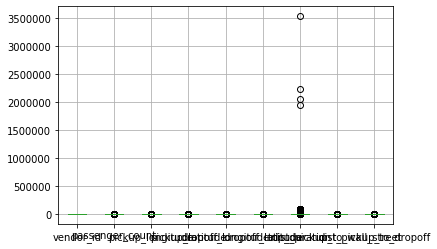

In [0]:
df.boxplot()

In [0]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist_pickup_to_wall_street,dist_pickup_to_dropoff
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,7.174609,1.500167
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,4.330734,1.807491
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.856819,6.392114
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.413665,1.487131
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,10.084072,1.189894


In [0]:
# df['dropoff_time'] = pd.to_datetime(df['dropoff_datetime'])
# df['pickup_time'] = pd.to_datetime(df['pickup_datetime'])

In [0]:
# df['temp_time_duration'] = df['dropoff_time'] - df['pickup_time']

In [0]:
# df['temp_time_duration_mins'] = df['temp_time_duration'] / np.timedelta64(1,'s')

In [0]:
# df.loc[df['temp_time_duration_mins'] - df['trip_duration']>0]

In [0]:
# plt.figure(figsize=(20,10))
# df.boxplot()

In order to extract the most relevant information from the
dataset for our purpose, we create a filtered dataset, in
which either the pick-up or drop-off location lies within
500 m from Wall Street (indicated by the red oval in Fig.
3(b)). In addition, we filter trips with unrealistically long
durations (>20 000 s).

In [0]:
df_wall = df[( df['dist_pickup_to_wall_street'] <= 0.5)& (df['trip_duration'] < 20000)]
df_wall.shape



(20535, 13)

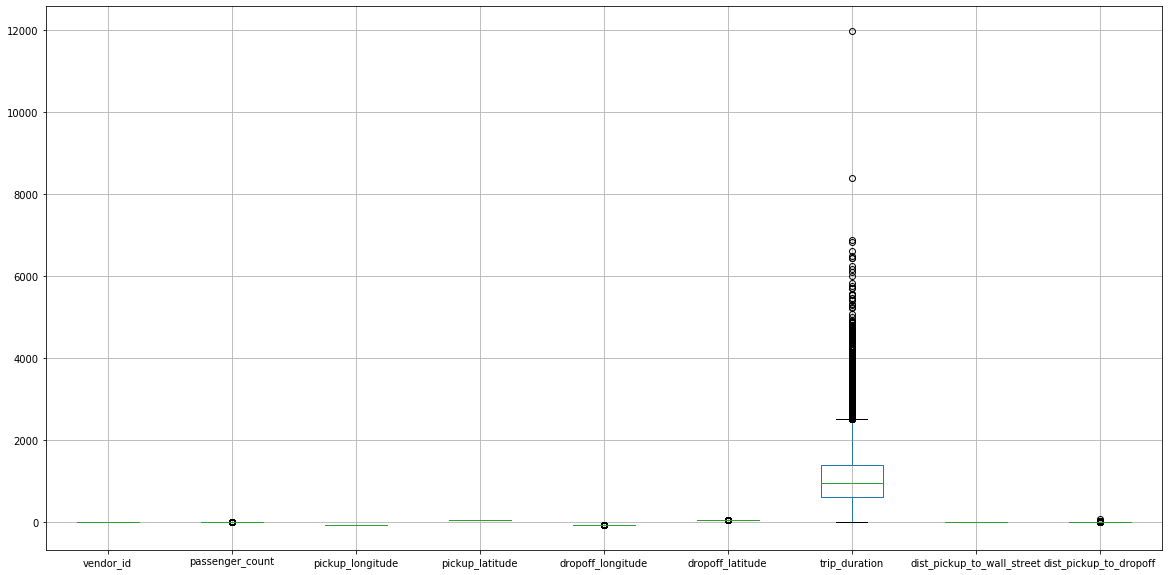

In [0]:
plt.figure(figsize=(20,10))
df_wall.boxplot()

### Choosing the prediction model

simply use 5 different prediction algorithm as the model, and compare its performance.

From this data, we will only use its location (dropoff_longitude and dropoff_latitude) and distance from the HQ to predict the trip duration.

In [0]:
 
temp_df = df_wall[['dropoff_latitude','dropoff_longitude','dist_pickup_to_dropoff','trip_duration']].copy()

# Declare the model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn import model_selection
from sklearn.model_selection import train_test_split
experiments = {"Algorithm":["Ordinary Least Squares", "Regression Tree", 
                            "Big Random Forest", "Random Forest", 
                            "Bagging"], 
               "Objects" : [lambda : LinearRegression(), 
                            lambda : DecisionTreeRegressor(), 
                            lambda : RandomForestRegressor(n_estimators=100), 
                            lambda : RandomForestRegressor(), 
                            lambda : BaggingRegressor()], 
               "Predictions":[[] for _ in range(5)]}
actuals = []

In [0]:
# run the 5 differenet algorithm and compare the result

for _ in range (4):
    train_X, test_X, train_y, test_y = (
        train_test_split(temp_df.drop("trip_duration", axis=1), 
                         temp_df["trip_duration"], test_size=0.33))
    for i, obj_factory in enumerate(experiments["Objects"]):
        obj = obj_factory()
        obj.fit(y=train_y,X=train_X)
        experiments["Predictions"][i] += list(obj.predict(test_X))
    actuals += list(test_y)
actuals = pd.Series(actuals)
experiments["Predictions"] = list(map(pd.Series, experiments["Predictions"]))

# Get the performance of every model
experiments["Results"] = []
for o in experiments["Objects"]:
    experiments["Results"].append(
        model_selection.cross_val_score(o(), y=temp_df['trip_duration'], 
                                        X=temp_df.drop("trip_duration", axis=1),
                                        cv=5).mean())

pd.DataFrame(experiments).drop(["Objects", "Predictions"], 
                            axis=1).set_index("Algorithm")

/Users/lilianaester/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/lilianaester/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/lilianaester/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/lilianaester/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/lilianaes

,Results
Algorithm,
Ordinary Least Squares,0.514720
Regression Tree,0.176965
Big Random Forest,0.530713
Random Forest,0.497428
Bagging,0.494900


Big random forest performance very well compare to the other. So, in this case, we will use big random forest as the algorithm for predicting trip duration. To easily re-produce the model, it is important to create the model in a function.

In [0]:
def create_model(df, HQ_location,sites_dictionary):
    '''
    parameter : 
        - df = the training dataframe
        - HQ_location = the headquarter
        - sites_dictionary = all location sites + HQ location
    '''
    train_X, test_X, train_y, test_y = ( train_test_split(df.drop("trip_duration", axis=1), 
                             df["trip_duration"], test_size=0.33))

    obj = RandomForestRegressor(n_estimators=100)
    obj.fit(y=train_y,X=train_X)
#     obj.predict(test_X)
    
#     print("Cross val score : ",model_selection.cross_val_score(obj, y=df['trip_duration'], 
#                                             X=df.drop("trip_duration", axis=1),
#                                             cv=5).mean())
#     obj.predict(df.drop("trip_duration", axis=1))

    ## CREATE THE SAMPLE FOR THE MODEL
    sample_lat = []
    sample_lng = []
    sample_distance = []

    for k,v in sites_dictionary.items():
        sample_lat.append(v[0])
        sample_lng.append(v[1])
        sample_distance.append(get_distance_between_points(HQ_location[0],HQ_location[1],v[0],v[1]))
        
    
    d = {
    'dropoff_latitude' : sample_lat,
    'dropoff_longitude' : sample_lng,
    'dist_pickup_to_dropoff': sample_distance
    }
    
    temp_pred_df = pd.DataFrame(d)  
    
    temp_pred_df['predicted_duration'] = obj.predict(temp_pred_df)
    return temp_pred_df

In [0]:
def get_location_names(lat,lng):
    for k,v in dict_location.items():
        if  (v[0] == lat) & (v[1] == lng) :
            return k
        

In [0]:
df1 = create_model(temp_df,dict_location["1"], dict_location)
df1

,dropoff_latitude,dropoff_longitude,dist_pickup_to_dropoff,predicted_duration
0,40.73000,-74.05000,0.000000,708.118333
1,40.66500,-73.79500,22.704878,2797.340000
2,40.77000,-73.99500,6.429525,1386.600000
3,40.74000,-73.99000,5.181914,1626.230000
4,40.69500,-73.95000,9.293823,1773.960000
5,40.76700,-73.87500,15.322028,2547.280000
6,40.70729,-74.01095,4.152766,1075.430000


In [0]:
prediction_list = []
for i in dict_location:
    tdf = create_model(temp_df,dict_location[str(i)], dict_location)
    prediction_list.append(list(tdf['predicted_duration'].apply(lambda x : int(x))))
    print(list(tdf['predicted_duration'].apply(lambda x : int(x))))

[931, 2701, 1322, 1489, 1761, 2232, 895]
[2494, 621, 2979, 2191, 1979, 2255, 2194]
[1964, 2858, 1319, 997, 1908, 2294, 1588]
[3355, 2499, 970, 1409, 1253, 2121, 904]
[1404, 2730, 1678, 1499, 1245, 1947, 1168]
[2198, 2616, 1660, 1414, 1738, 1144, 2027]
[943, 2525, 1326, 1213, 1087, 1790, 421]


In [0]:
for i in range(len(prediction_list)):
    prediction_list[i][i] = 0
prediction_list


[[0, 2701, 1322, 1489, 1761, 2232, 895],
 [2494, 0, 2979, 2191, 1979, 2255, 2194],
 [1964, 2858, 0, 997, 1908, 2294, 1588],
 [3355, 2499, 970, 0, 1253, 2121, 904],
 [1404, 2730, 1678, 1499, 0, 1947, 1168],
 [2198, 2616, 1660, 1414, 1738, 0, 2027],
 [943, 2525, 1326, 1213, 1087, 1790, 0]]

In [0]:
%load_ext iminizinc

<IPython.core.display.Javascript object>

MiniZinc to FlatZinc converter, version 2.3.0, build 68017672
Copyright (C) 2014-2019 Monash University, NICTA, Data61


In [0]:
# Data for Minizinc
dist = prediction_list
NumLocs= 7;
surveyTime = 1800

In [0]:
%%mzn_model taxi_model
%
% Vehicle Routing Problem
%

% Location data

% Locations
int: NumLocs;
set of int: Locations = 1..NumLocs;

array [Locations, Locations] of int: dist;


% Survey
int: N = NumLocs - 1;

% Vehicles
int: NumRoutes = 4*N; % Worst Case 
set of int: Vehicles = 1..NumRoutes;  % One Vehicle for each Route

% Survey Time
% We assume that the amount of time it takes to do a survey is constant, e.g. 70000 seconds
int: surveyTime;


% =====================================
% Model
% =====================================

include "globals.mzn";

% Define sets of nodes

% Survey locations have 2 states, a start and an end state
set of int: ArriveSurvey = 1..N;
set of int: LeaveSurvey = N+1..2*N;
% 1..2*N represent survey nodes, anything greater is a Depot Node  
% At the worst case, A taxi will visit all survey nodes
set of int: TaxiStart1 = 2*N+1..4*N;  % All Starting Nodes for Taxi 1
set of int: TaxiStart2  = 4*N+1..6*N; % All Starting Nodes for Taxi 2
set of int: Taxi = 1..4*N; % All Taxis
set of int: TaxiEnd1 = 6*N+1..8*N; % All Ending Nodes for Taxi 1
set of int: TaxiEnd2 = 8*N+1..10*N; % All Ending Nodes for Taxi 2

% All Nodes
set of int: Visits = 1..max(TaxiEnd2);
% All Survey Nodes plus Taxi Starting Nodes
set of int: SurveyPlusStarts = 1..max(TaxiStart2);


% Array of Distances between 2 points i and j
% Extended array of distances, including the depot start/end nodes.
array[Visits,Visits] of int: visit_dist = array2d(Visits,Visits,
  [if i> 2 * N /\ j > 2 * N then 0  % Distance between Depots
   elseif i > 2 * N then dist[NumLocs,(j mod N) + 1] % Distance between Depots and Survey (i > Survey)
   elseif j> 2 * N then dist[(i mod N)+1,NumLocs] % Distance between Survey and Depot (j > Survey)
   elseif i + N = j then 0
   elseif j + N = i then 0               % Distance between the same depots is 0
   else dist[(i mod N)+1 ,(j mod N)+1] endif | i,j in Visits]); % Euclidean Distance for the rest

% =====================================
% Decision variables
% =====================================

% Successor representation
array[Visits] of var Visits: successor;

% Time (i-th element is the time when the taxi visits the i-th node)
array[Visits] of var 0..infinity: time;
% Time (i-th element is the time when the i-th survey starts)
array[ArriveSurvey] of var 0..infinity: surveyStart;

% Mapping from visits to route (vehicle) number
array[Visits] of var Vehicles: routeOf;

% Objective function:
% Maximum time taken to complete all surveys
var int: objective = max(time);

% =====================================
% Problem Constraints
% =====================================

% Route & Successor Constraints
% =====================================

% Assign each vehicle depot start node to its route
constraint forall (k in Taxi) ( routeOf[2*N + k] = k);

% Assign each vehicle depot end node to its route
constraint forall (k in Taxi) ( routeOf[6*N + k] = k);

% The successors form a circuit (grand tour representation)
constraint circuit (successor) ::domain;

% successor of an ending taxi node is the next starting taxi node, wraps around to first depot node
constraint
  forall (k in Taxi)
    ( successor[6*N + k] = ( 2*N + 1 + (k mod NumRoutes) ) );

% Successor of starting survey node can only be a depot node or an ending survey node
constraint forall(k in ArriveSurvey)(successor[k] > N);
% Sucessor of ending survey node can only be a depot node or a starting survey node
constraint forall(k in LeaveSurvey)(successor[k] <= N \/ successor[k] >= 2*N + 1);
    
% Link up the routeOf and successor variables:
% Each visit is on the same route as its successor.
% This is true for all survey and start visits, but not for the end visits.
constraint forall (i in SurveyPlusStarts) ( routeOf[i] = routeOf[successor[i]] );


% =====================================
% Survey Constraints
% =====================================

% Survey i should start after or at the time the survey team reaches survey site i
constraint forall(i in ArriveSurvey)(surveyStart[i] >= time[i]);
% The time the taxi leaves from survey site i should be after 1800 seconds from the time the survey starts
constraint forall(i in ArriveSurvey)(surveyStart[i] + surveyTime <= time[i + N]);

% This constraint makes sure that at any given time, only 2 surveys maybe be done in parallel
% It takes in an array of start times, the amount of time it takes to finish the survey, how many survey teams are used for that survey, and the maximum number of survey teams available
constraint cumulative(surveyStart, [surveyTime | i in 1..N], [1 | i in 1..N], 2);

% =====================================
% Time Constraints
% =====================================

% Accumulate Time
constraint forall(i in Visits where i != 4 * N - 1 /\ i != 6 * N - 1)(time[successor[i]] >= time[i] + visit_dist[i, successor[i]]);

% Starting Taxi times are 0, at 2n + 1 and 4n + 1
constraint time[2 * N + 1] = 0;
constraint time[4 * N + 1] = 0;

% Ending Depot Time should be the same as the next Starting Depot Time, for each Taxi
constraint forall(i in 1..2, j in 1..2*N-1)(time[6*N + j + (i-1)*N] = time[2*N + j + 1 + (i-1)*N]);
  

% =====================================
% Symmetry breaking
% =====================================

% If the successor of the i-th starting taxi node is its ending taxi node, then the successor of 
% the (i+1)-th starting taxi node will also be its corresponding ending taxi node
constraint forall(i in 1..2*N-1) (successor[2*N+i] = 6*N + i -> successor[2*N+i+1] = 6*N + i + 1);

% =====================================
% Solve and output
% =====================================

% We want to minimize the time taken to complete all surveys
solve
  :: int_search ( successor, dom_w_deg, indomain_min, complete)
  minimize (objective);

output
[ "objective = ", show(objective), "\n" ] ++
[ "successor = ", show(successor), ";\n" ] ++
[ "routeOf = ", show(routeOf), ";\n"] 
++ [ "time = ", show(time), ";\n"]
++ [ "surveyStart = ", show(surveyStart), ";\n"];

In [0]:
output = %minizinc taxi_model -t 30000 --solver chuffed
print(output)

% Warning: Unknown or not support variable selection annotation 'dom_w_deg'! Ignore variable selection annotation and replace it by 'input_order'.
Solver output:
Time limit exceeded!
{'successor': [7, 8, 9, 10, 11, 12, 3, 4, 37, 49, 2, 1, 6, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 5, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 13], 'time': [5444, 5250, 9435, 8958, 1790, 943, 7244, 7050, 11235, 10758, 3590, 2743, 0, 12139, 12139, 12139, 12139, 12139, 12139, 12139, 12139, 12139, 12139, 0, 0, 11926, 11926, 11926, 11926, 11926, 11926, 11926, 11926, 11926, 11926, 0, 12139, 12139, 12139, 12139, 12139, 12139, 12139, 12139, 12139, 12139, 0, 0, 11926, 11926, 11926, 11926, 11926, 11926, 11926, 11926, 11926, 11926, 0, 0], 'surveyStart': [5444, 5250, 9435, 8958, 1790, 943], 'routeOf': [1, 13, 1, 13, 13, 1, 1, 13, 1, 13, 13, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22

In [0]:
successor = output['successor']
surveyStart = output['surveyStart']
routeOf = output['routeOf']
time= output['time']

In [0]:
n = NumLocs-1
list_taxi1 = []
taxi = "taxi1"
start_point = 2*n + 1

for i in range(len(successor)): 
    temp_start = start_point
    start_point = successor[start_point-1]
    
    # Origin and Destination node
    start_node = temp_start
    end_node = successor[temp_start-1]

    if (end_node > 2*n ):
        state = "HQ"
    elif end_node <= 2*n :
        if int(start_node) != int(end_node - n):
            if end_node > n:
                place = end_node - n
            else :
                place = end_node
        if place == start_node:
            # pick up surveyor
            place = 0
        state = "go to Place " + str(place)
    
    list_taxi1.append([taxi, state,start_node,end_node,time[temp_start-1],time[start_point-1]])
    temp_start = start_point
    if i == 4*n+1 :
        taxi = "taxi2"
        
result_taxi_df = pd.DataFrame(list_taxi1)
result_taxi_df.columns = ["taxi","state","start_node","end_node","start","end"]
# result_taxi_df

In [0]:
ress_df = result_taxi_df.loc[(result_taxi_df.start != result_taxi_df.end) & (result_taxi_df.end != 0 )]
ress_df

,taxi,state,start_node,end_node,start,end
0,taxi1,go to Place 6,13,6,0,943
1,taxi1,go to Place 0,6,12,943,2743
2,taxi1,go to Place 1,12,1,2743,5444
3,taxi1,go to Place 0,1,7,5444,7244
4,taxi1,go to Place 3,7,3,7244,9435
5,taxi1,go to Place 0,3,9,9435,11235
6,taxi1,HQ,9,37,11235,12139
30,taxi2,go to Place 5,25,5,0,1790
31,taxi2,go to Place 0,5,11,1790,3590
32,taxi2,go to Place 2,11,2,3590,5250


In [0]:
survey_time = 1800

survey2_start_end = []
for idx,i in enumerate(surveyStart):
    survey2_start_end.append(["tsurvey" + str(idx+1),i,i+survey_time])
    
    

survey2_df = pd.DataFrame(survey2_start_end)
survey2_df.columns = ["taxi","start","end"]

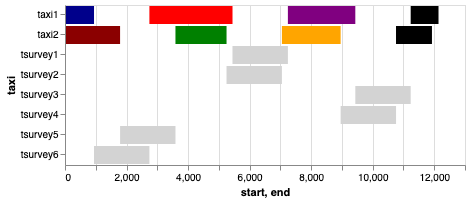

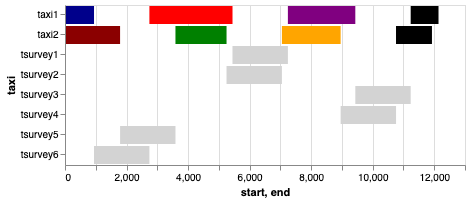

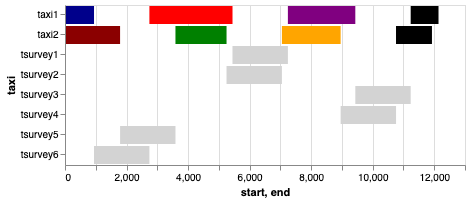

In [0]:

alt.renderers.enable('notebook')

color = ['black','red',  'green', 'purple', 'orange', 'darkred',  'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'lightgray']


backHQ = alt.Chart(ress_df[(ress_df.state == "HQ") ]).mark_bar(color=color[0]).encode(x='start',x2='end',y='taxi')

goto = []
for i in range(n):
    goto.append(alt.Chart(ress_df[(ress_df['state'].str[-1] == str(i+1)) ]).mark_bar(color=color[i+1]).encode(x='start',x2='end',y='taxi'))

surveys = alt.Chart(survey2_df).mark_bar(color=color[len(color)-1]).encode(x='start',x2='end',y='taxi')

graph_all = backHQ

for i in range(len(goto)):
    graph_all = graph_all + goto[i]
graph_all + surveys




In [0]:
# import libraries
import folium
import pandas as pd
 
lat_list = []
lon_list= []
color_list= []
for idx,i in enumerate(dict_location):
    lat_list.append(dict_location[i][0])
    lon_list.append(dict_location[i][1])
    color_list.append(color[idx])
    
color_list
    
# Make a data frame with dots to show on the map
data = pd.DataFrame({
'lat': lat_list,
'lon': lon_list,
'name':['HQ','1','2','3','4','5','6'],
'color_list' : color_list
})
data
 
# Make an empty map
# m = folium.Map(location=[20, 0], tiles="Mapbox Bright", zoom_start=2)
m = folium.Map(location=[mean(lat_list), mean(lon_list)], tiles="cartodbpositron", zoom_start = 11)

 
# I can add marker one by one on the map
for i in range(0,len(data)):
    folium.Marker([data.iloc[i]['lat'], data.iloc[i]['lon']], popup=data.iloc[i]['name'], icon=folium.Icon(color=data.iloc[i]['color_list'], icon='none')).add_to(m)

m

## References
Ikonen, T. J., & Harjunkoski, I. (2019). Incorporation of parameter prediction models of different fidelity into job shop scheduling. IFAC-PapersOnLine, 52(1), 142-147. doi:10.1016/j.ifacol.2019.06.051